# Model 1: Using CNN's with the Skin Type Dataset

For the first model we will use the `skin type` dataset to train a model that can classify 3 skin types. For this, we will create own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
from google.colab import files

<a name="2"></a>
## Dataset exploration

Let's explore the dataset in the folder `./SkinType`. There is a subdirectory for each class, so one for dogs and one for cats. The complete tree looks like this:

```
.
└── SkinType/
    ├── Normal/
    │   ├── normal_1.jpg
    │   ├── normal_2.jpg
    │   └── ...
    └── Dry/
        ├── dry_1.jpg
        ├── dry_2.jpg
    |   └── ...
    └── Oily/
        ├── oily_1.jpg
        ├── oily_2.jpg
        └── ...

```

In [ ]:
# Directory that holds the data
DATA_DIR = '/content/drive/My Drive/Skin Type/SkinType'

# Subdirectories for each class
data_dir_normal = os.path.join(DATA_DIR, 'Normal')
data_dir_dry = os.path.join(DATA_DIR, 'Dry')
data_dir_oily = os.path.join(DATA_DIR, 'Oily')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_normal))} images of normal skin type.")
print(f"There are {len(os.listdir(data_dir_dry))} images of dry skin type.")
print(f"There are {len(os.listdir(data_dir_oily))} images of oily skin type.")

There are 661 images of normal skin type.
There are 661 images of dry skin type.
There are 661 images of oily skin type.


Haiii

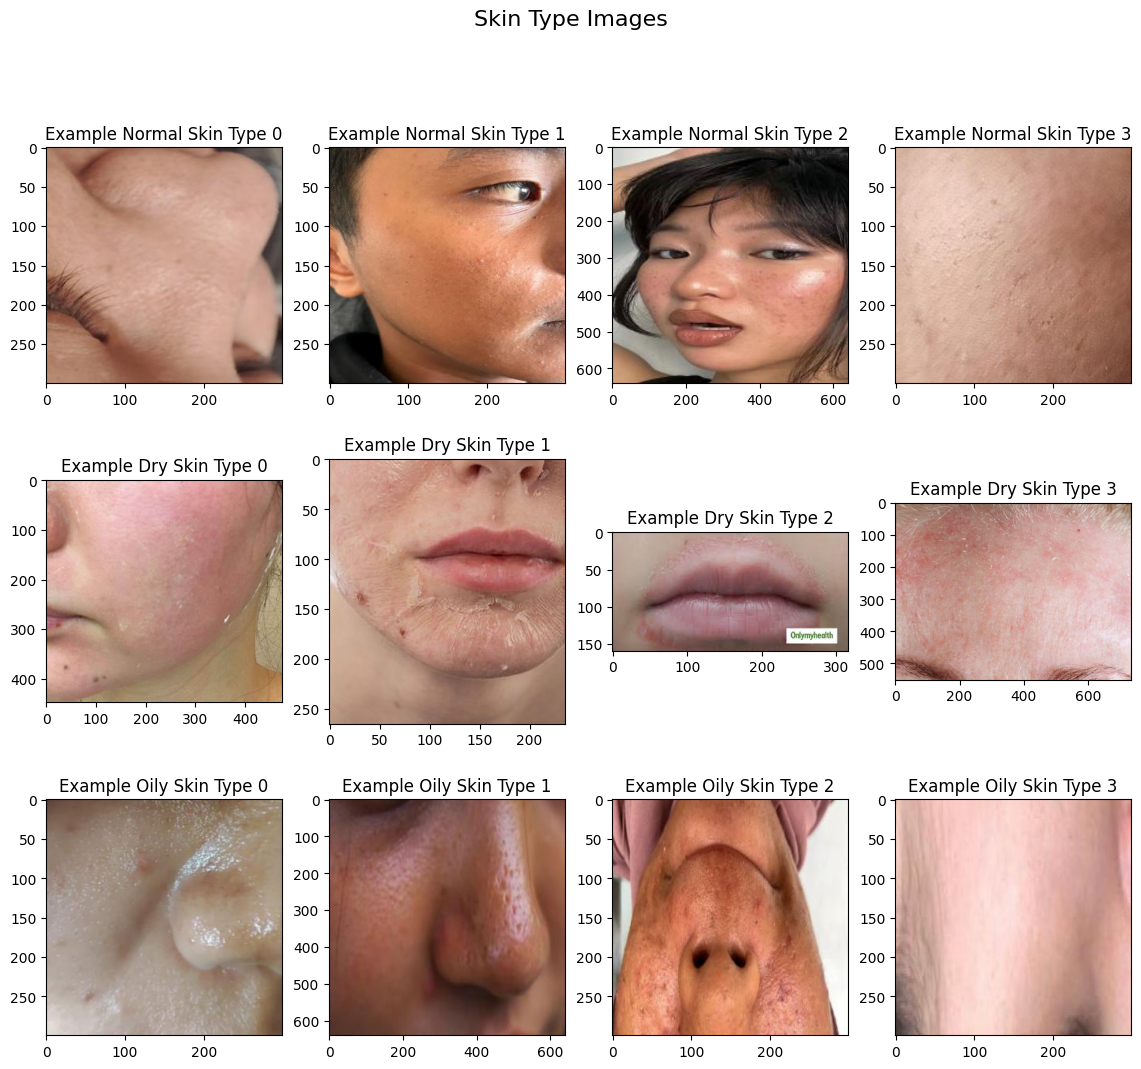

In [ ]:
# Get the filenames
normal_filenames = [os.path.join(data_dir_normal, filename) for filename in os.listdir(data_dir_normal)]
dry_filenames = [os.path.join(data_dir_dry, filename) for filename in os.listdir(data_dir_dry)]
oily_filenames = [os.path.join(data_dir_oily, filename) for filename in os.listdir(data_dir_oily)]

num_examples = 4

random_normal = random.sample(normal_filenames, num_examples)
random_dry = random.sample(dry_filenames, num_examples)
random_oily = random.sample(oily_filenames, num_examples)

fig, axes = plt.subplots(3, num_examples, figsize=(14, 12))
fig.suptitle('Skin Type Images', fontsize=16)

# Plot the first 4 images of each class
for i, normal_image in enumerate(random_normal):
    img = tf.keras.utils.load_img(normal_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Normal Skin Type {i}')

for i, dry_image in enumerate(random_dry):
    img = tf.keras.utils.load_img(dry_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dry Skin Type {i}')

for i, oily_image in enumerate(random_oily):
    img = tf.keras.utils.load_img(oily_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Oily Skin Type {i}')

plt.show()

In [ ]:
def train_val_datasets():
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory= DATA_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='both',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 1977 files belonging to 3 classes.
Using 1582 files for training.
Using 395 files for validation.


In [ ]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128, 3)


## Data Augmentation

In [ ]:
def create_augmentation_model():

    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
    ])
    return augmentation_model

In [ ]:
def demo_augmentation(sample_image, model, num_aug):

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

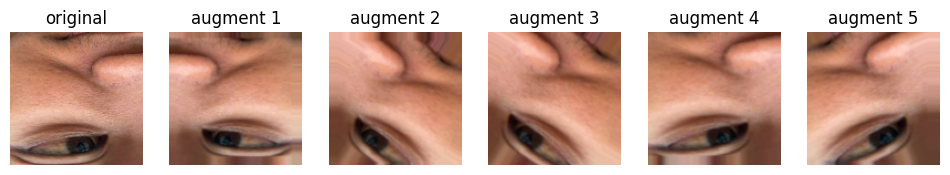

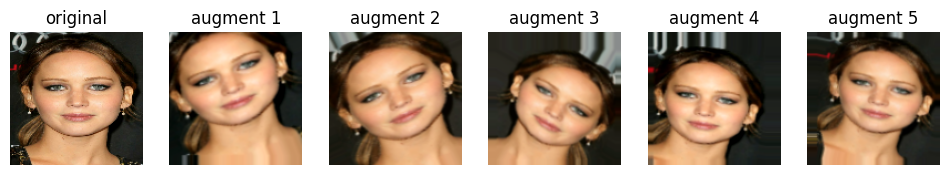

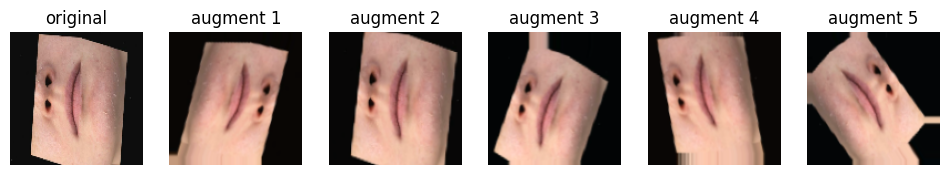

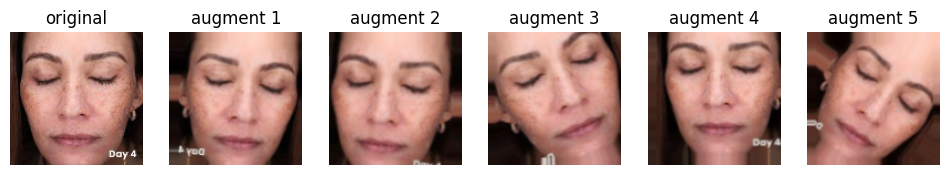

In [ ]:
NUM_AUG = 5

# Get a batch of images
sample_batch = list(training_dataset.take(1))[0][0]

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[1], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[2], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[3], create_augmentation_model(), NUM_AUG)

# Delete the variable to free up some memory
del sample_batch

##Create Model

In [ ]:
def create_model():
    # Data Augmentation Layers
    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),  # Input shape harus sesuai dataset
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),  # Rescale image to [0,1]

        # Convolutional Layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Fully Connected Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')  # Output layer untuk 3 kelas
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Ganti ke categorical jika target one-hot encoded
                  metrics=['accuracy'])

    return model


In [ ]:
model = create_model()
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 120, 120, 3)
Output shape: (None, 3)


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,862,659 (10.92 MB)

 Trainable params: 2,862,659 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
	training_dataset,
	epochs=60,
	validation_data=validation_dataset,
)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 231s 18s/step - accuracy: 0.3375 - loss: 1.1311 - val_accuracy: 0.3013 - val_loss: 1.1018
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - accuracy: 0.3698 - loss: 1.0930 - val_accuracy: 0.4532 - val_loss: 1.0851
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.4232 - loss: 1.0830 - val_accuracy: 0.4987 - val_loss: 1.0529
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 569ms/step - accuracy: 0.4717 - loss: 1.0468 - val_accuracy: 0.4937 - val_loss: 1.0082
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.4499 - loss: 1.0402 - val_accuracy: 0.5418 - val_loss: 0.9989
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 594ms/step - accuracy: 0.5301 - loss: 0.9935 - val_accuracy: 0.5215 - val_loss: 0.9795
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 605ms/step - accuracy: 0.5542 - loss: 0.9662 - val_accuracy: 0.5367 - val_loss: 0.9996
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 521ms/step - accuracy: 0.5117 - loss: 0.9993 - val_accuracy

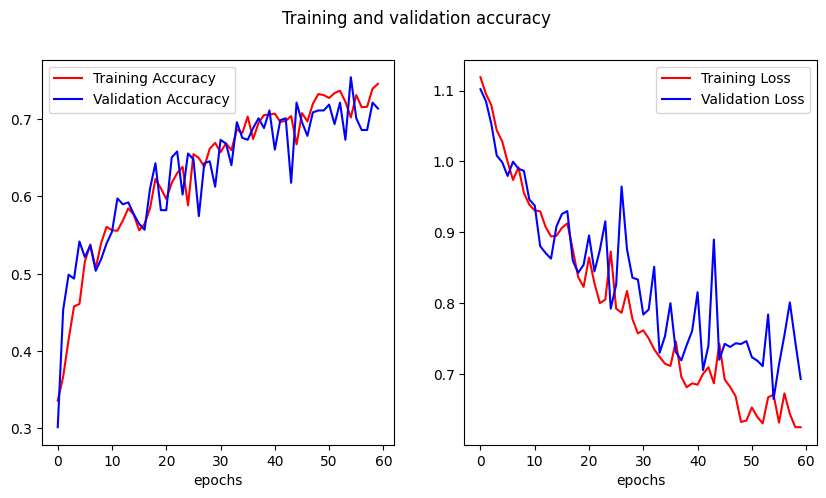

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# Langkah 1: Simpan model dengan ekstensi .keras
model.save('skin_type_model.keras')  # Menyimpan model dengan ekstensi .keras

# Langkah 2: Download model yang sudah disimpan
files.download('skin_type_model.keras')  # Mendownload file model ke komputer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import gc  # Untuk membersihkan memori


# Fungsi untuk memprediksi gambar
def predict_image(img_path):
    # Load dan preprocess gambar
    img = Image.open(img_path).resize((120, 120))  # Sesuaikan ukuran dengan model Anda
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi (jika diperlukan)

    # Prediksi menggunakan model
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=1)[0]

    # Label kelas (sesuaikan dengan dataset Anda)
    class_labels = ['Oily', 'Normal', 'Dry']
    predicted_class = class_labels[class_idx]
    confidence = predictions[0][class_idx]

    return predicted_class, confidence

# Unggah dan proses file
uploaded = files.upload()
for file_name in uploaded.keys():
    print(f"File yang diunggah: {file_name}")
    # Lakukan prediksi
    predicted_class, confidence = predict_image(file_name)
    print(f"Hasil Prediksi: {predicted_class} (Confidence: {confidence:.2f})")

    # Bersihkan memori
    del predicted_class, confidence  # Hapus variabel prediksi
    gc.collect()  # Bersihkan memori runtime
    print(f"Prediksi untuk {file_name} selesai dan memori telah dibersihkan.")


Saving oily.jpg to oily (1).jpg
Saving download.jpeg to download (3).jpeg
File yang diunggah: oily (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Hasil Prediksi: Dry (Confidence: 0.99)
Prediksi untuk oily (1).jpg selesai dan memori telah dibersihkan.
File yang diunggah: download (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Hasil Prediksi: Dry (Confidence: 0.99)
Prediksi untuk download (3).jpeg selesai dan memori telah dibersihkan.


In [ ]:
from tensorflow.keras.backend import clear_session

# Hapus cache dan sesi model
clear_session()


In [ ]:
import os

os.listdir(DATA_DIR)

['Oily', 'Normal', 'Dry']